# Lab Assignment 7: Evaluation and Multi-Layer Perceptron
## Rupal Sanghavi, Omar Roa, Van Tran

## Preparation

This dataset represents the responses from students and their friends(ages 15-30, henceforth stated as "young people") of a Statistics class from the Faculty of Social and Economic Sciences at The Comenius University in Bratislava, Slovakia. Their survey was a mix of various topics.

* Music preferences (19 items)
* Movie preferences (12 items)
* Hobbies & interests (32 items)
* Phobias (10 items)
* Health habits (3 items)
* Personality traits, views on life, & opinions (57 items)
* Spending habits (7 items)
* Demographics (10 items)

The dataset can be found here. https://www.kaggle.com/miroslavsabo/young-people-survey

Our target is to predict how likely a young person would spend money on gadgets. 

We wanted to find a classifer that would interest advertisers. Many of the questions asked here may not be something readily available or something that can be scraped from social media. These include phobias and spending habits that aren't the likeliness of spending money on gadgets. 

After discussion and advice from Dr. Larson, we decided to keep our dataset with the understanding that our Wide and Deep networks will not be very deep or wide compared to groups with larger data sets.



### Define and prepare class variables


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import make_scorer
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

target_classifier = 'Spending on gadgets'
df = pd.read_csv('responses.csv', sep=",")
desired_features = ["Music","Dance","Folk","Country","Classical music","Musical",
    "Pop","Rock","Metal or Hardrock","Punk","Hiphop, Rap","Reggae, Ska",
    "Swing, Jazz","Rock n roll","Alternative","Latino","Techno, Trance",
    "Opera","Movies","Horror","Thriller","Comedy","Romantic","Sci-fi","War",
    "Fantasy/Fairy tales","Animated","Documentary","Western","Action","History",
    "Psychology","Politics","Mathematics","Physics","Internet","PC","Economy Management",
    "Biology","Chemistry","Reading","Geography","Foreign languages","Medicine","Law",
    "Cars","Art exhibitions","Religion","Countryside, outdoors","Dancing",
    "Musical instruments","Writing","Passive sport","Active sport","Gardening","Celebrities",
    "Shopping","Science and technology","Theatre","Fun with friends","Adrenaline sports",
    "Pets","Smoking","Alcohol","Healthy eating","Spending on gadgets","Age","Height","Weight",
    "Number of siblings","Gender","Left - right handed","Education","Village - town","House - block of flats"
]

df = df[desired_features]
df.head()

,Music,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,...,Spending on gadgets,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Village - town,House - block of flats
0,5.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,...,1,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,village,block of flats
1,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,...,5,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,city,block of flats
2,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,...,4,20.0,176.0,67.0,2.0,female,right handed,secondary school,city,block of flats
3,5.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,...,4,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,city,house/bungalow
4,5.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,2.0,...,2,20.0,170.0,59.0,1.0,female,right handed,secondary school,village,house/bungalow


The list above is our desired attributes. We are not including phobias, spending habits (that aren't spending on gadgets), being an only child (as number of siblins answers the same question), and views on life and opinions (we thought that the questions asked would not be indicative of data that would be scraped.

In [2]:
df.rename(columns={'Reggae, Ska': 'ReggaeSka', 'Swing, Jazz': 'SwingJazz', 'Classical music': 'Classicalmusic', 'Metal or Hardrock': 'MetalorHardrock', 'Hiphop, Rap': 'HiphopRap', 'Rock n roll': 'Rocknroll', 'Techno, Trance': 'TechnoTrance', 'Sci-fi': 'Scifi', 'Fantasy/Fairy tales': 'Fantasy', 'Economy Management': 'EconomyManagement', 'Foreign languages': 'Foreignlanguages', 'Art exhibitions': 'Artexhibitions', 'Countryside, outdoors': 'outdoors', 'Musical instruments': 'Musicalinstruments', 'Passive sport': 'Passivesport', 'Active sport': 'Activesport', 'Science and technology': 'Scienceandtechnology', 'Fun with friends': 'Funwithfriends', 'Adrenaline sports': 'Adrenalinesports', 'Healthy eating': 'Healthyeating', 'Spending on gadgets': 'Spendingongadgets', 'Number of siblings': 'Numberofsiblings', 'Left - right handed': 'Leftrighthanded', 'Village - town': 'Villagetown', 'House - block of flats': 'Houseblockofflats'}, inplace=True)

We are renaming some columns so they can work with Tensor Flow.

### Choosing Cross Product Features

We chose the following combination of categorical features to be a cross product features:
* ('Smoking','Alcohol')
* ('Villagetown', 'Houseblockofflats')
* ('Villagetown', 'Education')

We would like to further explore using some of our data that ranks (1-5) as a category. At this point we did not due to constraints with time and issues with getting our code to work with Tensor Flow.

### Splitting Data
We chose to do a simple shuffle split over a stratified k-fold split. Ideally we would like to do a k-fold split, but the time used to train such a large amount of information is too much.

In [3]:
from copy import deepcopy
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2)

In [4]:
import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a cop

,Music,Dance,Folk,Country,Classicalmusic,Musical,Pop,Rock,MetalorHardrock,Punk,...,Spendingongadgets,Age,Height,Weight,Numberofsiblings,Gender,Leftrighthanded,Education,Villagetown,Houseblockofflats
387,5.0,5.0,2.0,2.0,2.0,4.0,5.0,2.0,1.0,1.0,...,5,25.0,167.0,64.0,2.0,female,right handed,masters degree,city,block of flats
699,5.0,4.0,3.0,1.0,2.0,3.0,5.0,3.0,1.0,2.0,...,2,20.0,170.0,50.0,1.0,female,right handed,secondary school,city,block of flats
470,4.0,4.0,3.0,1.0,2.0,3.0,5.0,2.0,1.0,1.0,...,1,19.0,167.0,58.0,1.0,female,right handed,secondary school,village,block of flats
497,5.0,3.0,3.0,3.0,4.0,4.0,5.0,5.0,2.0,3.0,...,2,20.0,165.0,60.0,1.0,female,right handed,secondary school,city,house/bungalow
797,5.0,5.0,1.0,2.0,3.0,4.0,2.0,2.0,1.0,1.0,...,4,19.0,185.0,65.0,1.0,male,right handed,secondary school,city,block of flats


## Processing

We will gather our categorical and numeric headers, and encode our categorical headers into integers.

In [5]:
categorical_headers = list(df.select_dtypes(include=['object']).columns)
numeric_headers = list(df.select_dtypes(include=['float']).columns) + list(df.select_dtypes(include=['int']).columns)

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoders = dict() 

for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=='Spendingongadgets':
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])

print(numeric_headers)
for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

['Music', 'Dance', 'Folk', 'Country', 'Classicalmusic', 'Musical', 'Pop', 'Rock', 'MetalorHardrock', 'Punk', 'HiphopRap', 'ReggaeSka', 'SwingJazz', 'Rocknroll', 'Alternative', 'Latino', 'TechnoTrance', 'Opera', 'Movies', 'Horror', 'Thriller', 'Comedy', 'Romantic', 'Scifi', 'War', 'Fantasy', 'Animated', 'Documentary', 'Western', 'Action', 'History', 'Psychology', 'Politics', 'Mathematics', 'Physics', 'Internet', 'PC', 'EconomyManagement', 'Biology', 'Chemistry', 'Reading', 'Geography', 'Foreignlanguages', 'Medicine', 'Law', 'Cars', 'Artexhibitions', 'Religion', 'outdoors', 'Dancing', 'Musicalinstruments', 'Writing', 'Passivesport', 'Activesport', 'Gardening', 'Celebrities', 'Shopping', 'Scienceandtechnology', 'Theatre', 'Funwithfriends', 'Adrenalinesports', 'Pets', 'Healthyeating', 'Age', 'Height', 'Weight', 'Numberofsiblings', 'Spendingongadgets']


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

### Evaluating our Algorithm's Performance

In [7]:
cost_matrix = np.matrix([
[0,1,2],
[1,0,1],
[3,1,0],
])

def get_confusion_costTot(confusion_matrix, cost_matrix, num_X):
    score = np.sum(confusion_matrix*cost_matrix)/num_X
    return score

confusion_scorer = make_scorer(get_confusion_costTot, greater_is_better=False)
confusion_scorer

make_scorer(get_confusion_costTot, greater_is_better=False)

We created a cost matrix with advice from IBM's Knowledge Center.
https://www.ibm.com/support/knowledgecenter/SSEPGG_10.5.0/com.ibm.im.model.doc/c_cost_matrix.html?lnk=hm

We heavily weighted having a false negative due to wasting money on someone who likely would not have interest in the topic and therefore not engage with the advirtisement. A false positive carries a higher weight than most but is still not the most severe because the money spent on advirtisements is not completely lost (but could be spent more efficiently). We also take into account the number of instances for scaling purposes.

The lower the score, the better our algorithm's performance.

In [8]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['Spendingongadgets'].values.astype(np.int)
y_test = df_test['Spendingongadgets'].values.astype(np.int)

print(feature_columns)

['Smoking_int', 'Alcohol_int', 'Gender_int', 'Leftrighthanded_int', 'Education_int', 'Villagetown_int', 'Houseblockofflats_int', 'Music', 'Dance', 'Folk', 'Country', 'Classicalmusic', 'Musical', 'Pop', 'Rock', 'MetalorHardrock', 'Punk', 'HiphopRap', 'ReggaeSka', 'SwingJazz', 'Rocknroll', 'Alternative', 'Latino', 'TechnoTrance', 'Opera', 'Movies', 'Horror', 'Thriller', 'Comedy', 'Romantic', 'Scifi', 'War', 'Fantasy', 'Animated', 'Documentary', 'Western', 'Action', 'History', 'Psychology', 'Politics', 'Mathematics', 'Physics', 'Internet', 'PC', 'EconomyManagement', 'Biology', 'Chemistry', 'Reading', 'Geography', 'Foreignlanguages', 'Medicine', 'Law', 'Cars', 'Artexhibitions', 'Religion', 'outdoors', 'Dancing', 'Musicalinstruments', 'Writing', 'Passivesport', 'Activesport', 'Gardening', 'Celebrities', 'Shopping', 'Scienceandtechnology', 'Theatre', 'Funwithfriends', 'Adrenalinesports', 'Pets', 'Healthyeating', 'Age', 'Height', 'Weight', 'Numberofsiblings', 'Spendingongadgets']


In [9]:
print(y_test)

[ 1  0 -1  0  0  0 -1  0  0 -1  0  0 -1  0  1  0  0  0  0  1  1  0  1  1  0
 -1 -1  0  0  1 -1 -1  0  0  1  1  1  0 -1  0 -1 -1  0  0  1  1  0  0  0  0
  0  0  0 -1  0  0  0 -1  0  0  0  0  0  1  0  0  0  1  1  0 -1  0  0 -1  1
  1  0  0  0  0  0  0  0  0  0 -1  1  0  0  0 -1  0  0 -1  1  0  0  0  0  0
  0  0  0  1 -1  0 -1  0  0  1  1  1  0  0  0  0  0  0  0  1  1  0  0  0 -1
  0  1 -1  0  1  0 -1  0 -1 -1  0 -1  0  0  0  0  0  1  1  0  1  0  0  0  0
  1 -1  1  1  0  0 -1  0  0  0  1  0 -1  1  0  1  0]


### Prediction Values

We reduced our prediction values to be 

*  -1    (Not Interested)
*    0   (Neutral)
*    1   (Interested)

This was a result of our Standard Scalar and us trying to get our data to work with tensor flow. Ideally we would like to predict a likeliness of 1-5 but could only get our data to work this way.

In [10]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
tf.logging.set_verbosity(tf.logging.WARN) # control the verbosity of tensor flow

In [11]:
# Let's start with the TF example (manipulated to work with new syntax)
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.expand_dims( # make it a column vector
                            tf.cast( # cast to a float32
                                tf.constant(df[k].values), 
                                tf.float32), 
                            1)
                       for k in numeric_headers}
    
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored as constant Tensors (numeric)
    # then use tensor flow to one hot encode them using the given number of classes 
    # name of encoder is **_int need to map only to **
    categorical_cols = {k: tf.one_hot(indices=tf.constant(df[k].values),
                                      depth=len(encoders[k[:-4]].classes_)) 
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label


In [12]:
# update the model to take input features as a dictionary
def my_model(dict_features, targets, mode):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    #=======DECODE FEATURES================
    # now let's combine the tensors from the input dictionary
    # into a list of the feature columns
    features = []
    #features = [dict_features[x] for x in numeric_headers+categorical_headers_ints]
    for col in numeric_headers:
        features.append(dict_features[col])
    
    # also add in the one hot encoded features
    for col in categorical_headers_ints:
        features.append(dict_features[col])
    
    # now we can just combine all the features together
    features = tf.concat(values=features,axis=1)
    
    # =====SETUP ARCHITECTURE=====
    # we can use functions from learn to add layers and complexity to the model
    # pass features through one hidden layer with relu activation
    features = layers.relu(features, num_outputs=50) 
    # now pass the features through a fully connected layer
    features = layers.fully_connected(features, num_outputs=1) 
    # and pass them through a sigmoid activation
    output_layer = tf.sigmoid(features) 
    # reshape the output to be one dimensional
    predictions = tf.reshape(output_layer, [-1])
    
    # depending on the mode, we may not want to evaluate these
    loss_mse = None
    train_op = None
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        # =====LOSS=======
        # we want to use MSE as our loss function
        loss_mse = tf.losses.mean_squared_error(targets, predictions) 
    
    if mode == learn.ModeKeys.TRAIN:
        # =====OPTIMIZER PARAMS========
        # now let's setup how we want thing to optimize 
        train_op = layers.optimize_loss(
            loss=loss_mse, 
            global_step=tf.contrib.framework.get_global_step(),
            optimizer='Adagrad', # adaptive gradient, so that the learning rate is not SO important 
            learning_rate=0.1)
    
    # what format to have the output in when calling clf.predict?
    predictions_out = predictions>0.5
    
    return model_fn_lib.ModelFnOps(
      mode=mode, predictions={'Spendingongadgets':predictions_out}, loss=loss_mse, train_op=train_op)

In [13]:
%%time
clf = learn.Estimator(model_fn=my_model)

# when we provide the process function, they expect us to control the mini-batch
clf.fit(input_fn=
        lambda:process_input(df_train,'Spendingongadgets',categorical_headers_ints, numeric_headers), 
        steps=500)

CPU times: user 7.83 s, sys: 322 ms, total: 8.15 s
Wall time: 6.74 s


In [14]:
yhat = clf.predict(input_fn=
                   lambda:process_input(df_test,None,categorical_headers_ints, numeric_headers))
# the output is now an iterable value, so we need to step over it
yhat = [x['Spendingongadgets'] for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_test.shape[1]))

[[ 0 29  0]
 [ 0 50 52]
 [ 0  0 36]] 6.8


The above model performed extremely poorly compared to the neural nets below.

In [15]:
# Now lets create a wide model 
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # not much changes here, except we leave the numerics as tc.constants
    continuous_cols = {k: tf.constant(df[k].values) for k in numeric_headers}
      
    # and we shift these tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df[k].size)],
                              values=df[k].values,
                              dense_shape=[df[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label


In [16]:
# update the model to take input features as a dictionary
def setup_wide_columns():
    # let's create the column structure that the learn API can expect
    
    wide_columns = []
    # add in each of the categorical columns
    for col in categorical_headers:
        wide_columns.append(layers.sparse_column_with_keys(col, keys=encoders[col].classes_))
        
    # also add in some specific crossed columns
    cross_columns = [('Smoking','Alcohol'), ('Villagetown', 'Houseblockofflats'), ('Villagetown', 'Education')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
                        
    return wide_columns

In [17]:
%%time

# ignore all the deprecations that the learn API needs to deal with... ugh
tf.logging.set_verbosity(tf.logging.ERROR)

# setup 
wide_columns = setup_wide_columns()
input_wrapper = lambda:process_input(df_train,'Spendingongadgets',categorical_headers, numeric_headers)
output_wrapper = lambda:process_input(df_test,None,categorical_headers, numeric_headers)

clf = learn.LinearClassifier(feature_columns=wide_columns)

# when we provide the process function, they expect us to control the mini-batch
clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0  29   0]
 [  0 100   2]
 [  0  35   1]] 4.53333333333
CPU times: user 27.3 s, sys: 1.29 s, total: 28.6 s
Wall time: 26.8 s


The wide model does well here. Much better than the previous deep model. This confirms that a wide model (memorization) works well on this dataset.

___

## Using Dense embeddings in a deeper network

In [18]:
# update the model to take input features as a dictionary
def setup_deep_columns():
    # now make up the deep columns
    
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        
        tmp = layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        
        deep_columns.append(
            layers.embedding_column(tmp, dimension=8)
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return deep_columns

In [19]:
%%time 

# setup deep columns
deep_columns = setup_deep_columns()
clf = learn.DNNClassifier(feature_columns=deep_columns, hidden_units=[100, 50])

clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0  29   0]
 [  0 100   2]
 [  0  33   3]] 4.58666666667
CPU times: user 34 s, sys: 1.32 s, total: 35.3 s
Wall time: 32 s


Performs almost exactly the same as our wide model. Sometimes a little worse or better, but always close to the same score.

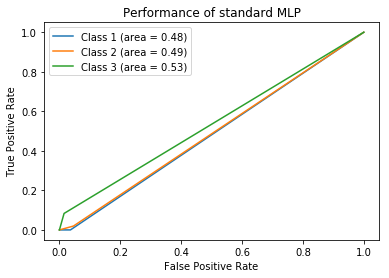

In [20]:
# graphing ROC
aucs = []
fprs = []
tprs = []

ind_yhat = yhat
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)
    # get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     yhat,
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))
plt.figure()
plt.title("Performance of standard MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for i in range(0,3):
    plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
               % (i+1, aucs[i]))
    plt.legend(loc='best')

plt.show()

### Second Deep Classifier
added a layer with 50 neurons

In [21]:
%%time 

# setup deep columns
deep_columns = setup_deep_columns()
clf = learn.DNNClassifier(feature_columns=deep_columns, hidden_units=[100, 50, 50]) #added hidden layer with 50 neurons

clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0  29   0]
 [  0 100   2]
 [  0  34   2]] 4.56
CPU times: user 33.8 s, sys: 1.34 s, total: 35.2 s
Wall time: 29.9 s


Every time we have run this, we have received the exact same score and confusion matrix as the first deep classifier. We conclude that adding more relu layers beyond the initial 100, 50 doesn't help.


___

## Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier which is already implemented! `learn.DNNLinearCombinedClassifier`

In [22]:
# update the model to take input features as a dictionary
def setup_wide_deep_columns():
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        )
        
        dim = round(np.log2(len(encoders[col].classes_)))
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    cross_columns = [('Smoking','Alcohol'), ('Villagetown', 'Houseblockofflats'), ('Villagetown', 'Education')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

In [23]:
%%time

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])


clf.fit(input_fn=input_wrapper, steps=2500)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[ 0 29  0]
 [ 0 99  3]
 [ 0 34  2]] 4.58666666667
CPU times: user 1min 14s, sys: 10.2 s, total: 1min 24s
Wall time: 1min 1s


Barely better than our deep model.

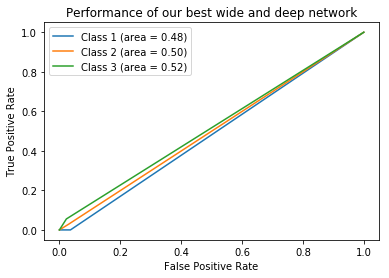

In [24]:
# graphing ROC
aucs = []
fprs = []
tprs = []

ind_yhat = yhat
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)
    # get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     yhat,
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))
plt.figure()
plt.title("Performance of our best wide and deep network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for i in range(0,3):
    plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
               % (i+1, aucs[i]))
    plt.legend(loc='best')

plt.show()

Our wide and deep network's AUC and ROC are comparatively similar to that of the standard multi-layer perceptron's. The AUCs are within 0.02 of each other. Class 2 seems to consistently have lower output quality, whereas the opposite is true for Class 1.

### Finding most important cross features
We will be doing this by creating models that each omit one of the cross features. The larger the drop in score tells us the more important the cross feature actually is.

In [25]:
# edit to pass in cross_columns
def setup_wide_deep_columns(cross_columns):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        )
        
        dim = round(np.log2(len(encoders[col].classes_)))
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

In [26]:
for i in range(3):
    cross_columns = [('Smoking','Alcohol'), ('Villagetown', 'Houseblockofflats'), ('Villagetown', 'Education')]
    cross_columns.remove(cross_columns[i])
    wide_columns, deep_columns = setup_wide_deep_columns(cross_columns)
    clf = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[100, 50])


    clf.fit(input_fn=input_wrapper, steps=2500)

    yhat = clf.predict(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    yhat = [x for x in yhat]
    conf_m = mt.confusion_matrix(y_test,yhat)
    print(conf_m,
          get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0  29   0]
 [  0 101   1]
 [  0  34   2]] 4.53333333333
[[  0  29   0]
 [  0 100   2]
 [  0  34   2]] 4.56
[[  0  29   0]
 [  0 100   2]
 [  0  34   2]] 4.56


In the above code, we removed each cross product feature individually and trained a model to find it's score. The model with the removed cross product feature that has the higher score means that the cross product feature is more important. Therefore

('Smoking', 'Alcohol') is our most important cross feature
('Villagetown', 'Education') is our next most important cross feature
('Villagetown', 'Houseblockofflats') was our least important cross feature

### Ending notes

We're a little dissapointed. Having deep and wide networks barely decreases the score. We also feel like there's a lot of room for improvement. For some reason the model has a hard time classifying the first target class.

We had many issues with our data preprocessing, as we followed too strict to the lecture's notebook. We think given more time, we can go over our data some more and get better results.

Also as you can see from the discussion of which cross product features are the most important.

Given more time, we would work with other classifiers, such as Age and interest in other hobbies (Biology or Chemistry) to see if those would work as cross product features.